<a href="https://colab.research.google.com/github/sushilyadav9713/names/blob/main/IndianMaleNameGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [116]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/sushilyadav9713/names/refs/heads/main/output_file.txt

--2025-03-29 13:15:38--  https://raw.githubusercontent.com/sushilyadav9713/names/refs/heads/main/output_file.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175716 (172K) [text/plain]
Saving to: ‘output_file.txt.1’

output_file.txt.1   100%[===================>] 171.60K  --.-KB/s    in 0.02s   

2025-03-29 13:15:38 (7.92 MB/s) - ‘output_file.txt.1’ saved [175716/175716]



In [117]:
words = open('output_file.txt', 'r').read().splitlines()
words[:8]

['baljraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash']

In [118]:
len(words)

14790

In [119]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: '\\', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'k', 14: 'l', 15: 'm', 16: 'n', 17: 'o', 18: 'p', 19: 'q', 20: 'r', 21: 's', 22: 't', 23: 'u', 24: 'v', 25: 'w', 26: 'x', 27: 'y', 28: 'z', 0: '.'}


In [120]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([128695, 3]) torch.Size([128695])
torch.Size([16062, 3]) torch.Size([16062])
torch.Size([16171, 3]) torch.Size([16171])


In [127]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((29, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 29), generator=g)
b2 = torch.randn(29, generator=g)
parameters = [C, W1, b1, W2, b2]

In [128]:
sum(p.nelement() for p in parameters) # number of parameters in total

12319

In [130]:
for p in parameters:
  p.requires_grad = True

In [129]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [131]:
lri = []
lossi = []
stepi = []

In [152]:
for i in range(20000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.01 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

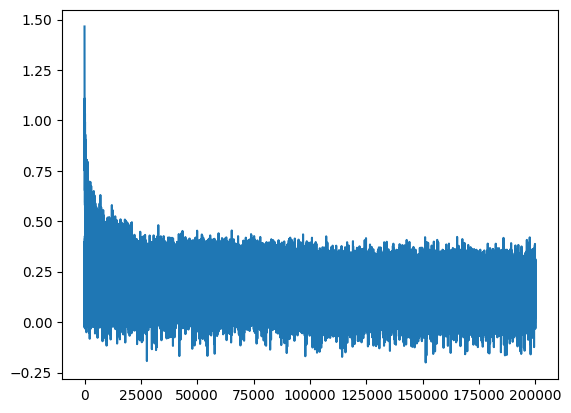

In [143]:
plt.plot(stepi, lossi)

In [153]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4613, grad_fn=<NllLossBackward0>)

In [155]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.5627, grad_fn=<NllLossBackward0>)

In [156]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5652, grad_fn=<NllLossBackward0>)

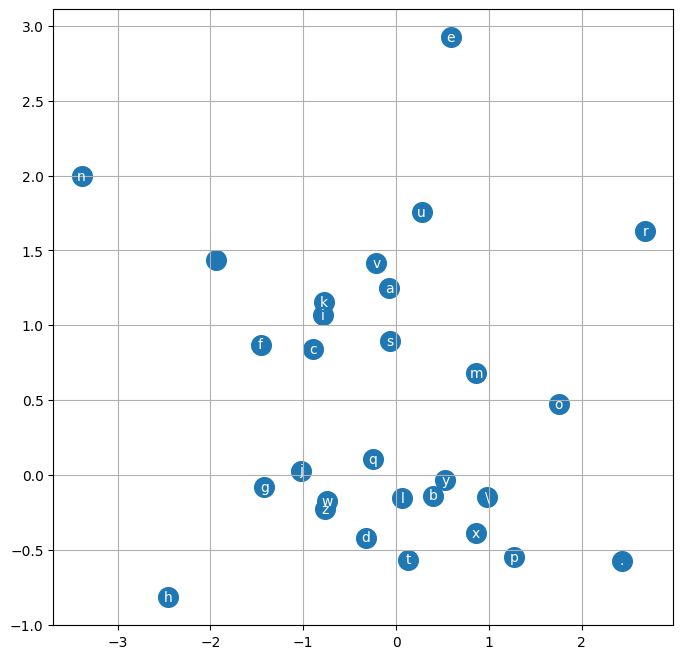

In [147]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [154]:
# sample from the model
g = torch.Generator().manual_seed(214748364)

for _ in range(200):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

nider bhooma.
mohmpatru.
sumit.
deep.
mit kumar.
rav dubtassyun kumawan.
gaur.
gufar.
om princhand.
sunil kit.
sunil kali prasim.
aloravi kur.
raj kish.
shivutdi.
dipal.
ram.
shivra sonu.
dandra.
sarand.
rohi lal singh.
sachinuj.
ram hushivashore.
arish ram kisulrij ram   mohan.
dharmanoj wopendra kumar.
nitender singh kumar.
mukesh.
viroz.
makashan kaari.
ind.
adilshartap kumar.
rijesh kumar.
balbir singh.
deepak.
visher singh.
mr khandal.
himru.
ankar.
dilashish kumar tharun.
abirender.
lishwariq.
hukla raghul.
sunil kumar.
mohd.
vijay kumar.
ju singh.
hand.
surav singh.
mush.
sokin rupiyukhti.
ram.
vipin.
ram.
pandey.
govinder.
rajedai shand.
mohit.
shra.
mho.
shukla.
md gayap.
chu pukesh.
haraya.
pivlarat  soni chor.
mohand.
gurja.
ralam.
kham.
nishnu.
chandayal.
yit.
vijay rampuranal meen kumanish.
parsh kumar tar.
gula rayat.
kand.
sham natendra.
ashoarwan lal kishor.
vijesh.
kuldeepak.
ram shan.
ravinderajatar.
gopal kumar.
sudeepak singh.
bal megra.
sahid.
ash.
kund.
deep  piwa